Loading and preparing data...
Features: ['x_au', 'y_au', 'z_au', 'vx_au_per_day', 'vy_au_per_day', 'vz_au_per_day']
Target: name (encoded)
Number of unique classes: 35
Class names: ['1 MERCURY BARYCENTER' '10 SUN' '199 MERCURY' '2 VENUS BARYCENTER'
 '299 VENUS' '3 EARTH BARYCENTER' '301 MOON' '399 EARTH'
 '4 MARS BARYCENTER' '5 JUPITER BARYCENTER' '6 SATURN BARYCENTER'
 '601 MIMAS' '602 ENCELADUS' '603 TETHYS' '604 DIONE' '605 RHEA'
 '606 TITAN' '607 HYPERION' '608 IAPETUS' '609 PHOEBE' '612 HELENE'
 '613 TELESTO' '614 CALYPSO' '632 METHONE' '634 POLYDEUCES' '699 SATURN'
 '7 URANUS BARYCENTER' '8 NEPTUNE BARYCENTER' '9 PLUTO BARYCENTER'
 '901 CHARON' '902 NIX' '903 HYDRA' '904 KERBEROS' '905 STYX' '999 PLUTO']
Data loading and initial preparation complete.

Training set shape: X_train=(47958, 6), y_train=(47958,)
Test set shape: X_test=(15987, 6), y_test=(15987,)

Preprocessing features with QuantileTransformer...
Feature preprocessing complete.

Training RandomForestClassifier with Gr

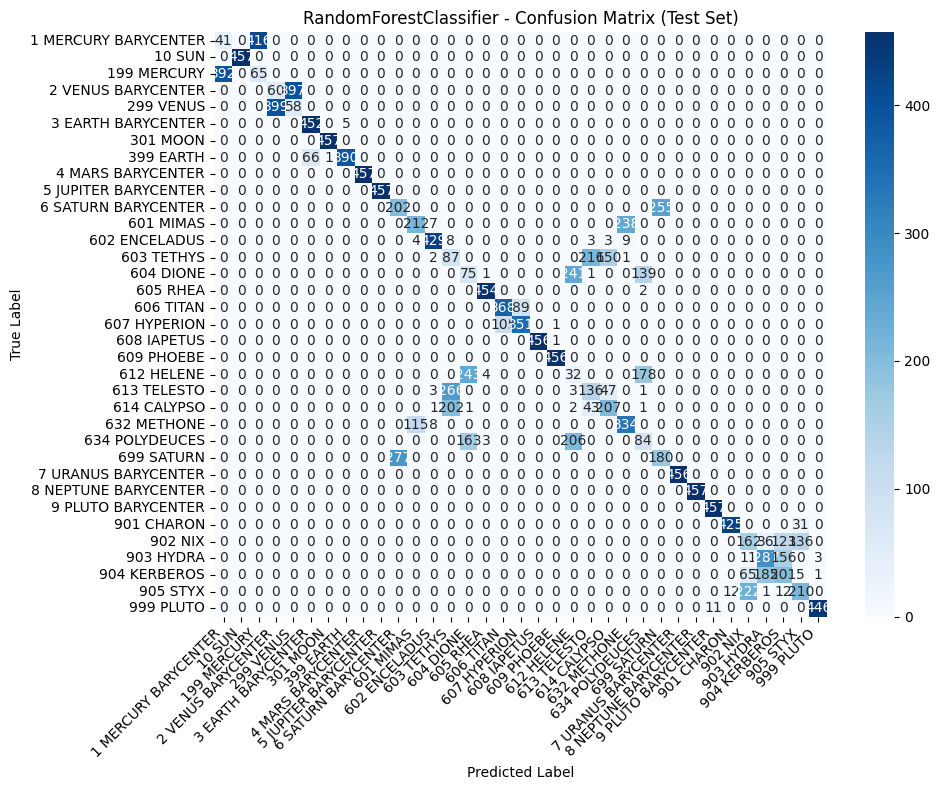



Summary of Accuracies and Times:
          Model  Train Accuracy  Test Accuracy  Training Time (s)  \
0  RandomForest        0.957254       0.629136         103.682539   

   Prediction Time (s)  
0              0.67356  

Total script execution time: 108.67 seconds

Potential improvements to consider:
- Explore other classification models (e.g., SVM, Gradient Boosting, Neural Networks).
- More extensive hyperparameter tuning for RandomForest or other models.
- If class imbalance is significant, apply techniques like SMOTE or class weighting.
- Feature engineering or selection if applicable.
- Cross-validation for more robust evaluation beyond a single train-test split during development.


In [7]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(file_path='./dataset/solar_system_positions_with_velocity.csv'):
    """Loads data, selects features and target, and encodes the target."""
    print("Loading and preparing data...")
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        print("Please ensure the CSV file is in the same directory as the script, or provide the full path.")
        return None, None, None, None

    # Define features and target
    feature_cols = ['x_au', 'y_au', 'z_au', 'vx_au_per_day', 'vy_au_per_day', 'vz_au_per_day']
    target_col = 'name'

    if not all(col in data.columns for col in feature_cols):
        print(f"Error: One or more feature columns not found in the CSV: {feature_cols}")
        return None, None, None, None
    if target_col not in data.columns:
        print(f"Error: Target column '{target_col}' not found in the CSV.")
        return None, None, None, None

    X = data[feature_cols]
    y_raw = data[target_col]

    # Encode target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_raw)
    
    print(f"Features: {feature_cols}")
    print(f"Target: {target_col} (encoded)")
    print(f"Number of unique classes: {len(label_encoder.classes_)}")
    print(f"Class names: {label_encoder.classes_}")
    print("Data loading and initial preparation complete.\n")
    return X, y, label_encoder, data

def preprocess_features(X_train, X_test):
    """Applies QuantileTransformer to features."""
    print("Preprocessing features with QuantileTransformer...")
    # Apply Quantile Transformation (inspired by the notebook)
    # Fit on training data only, then transform both train and test
    qt_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
    
    X_train_scaled = qt_transformer.fit_transform(X_train)
    X_test_scaled = qt_transformer.transform(X_test)
    
    # Convert back to DataFrame to keep column names (optional, but good for inspection)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print("Feature preprocessing complete.\n")
    return X_train_scaled_df, X_test_scaled_df, qt_transformer

def train_random_forest(X_train, y_train):
    """Trains a RandomForestClassifier using GridSearchCV."""
    print("Training RandomForestClassifier with GridSearchCV...")
    model_name = "RandomForest"
    
    # Parameter grid for Random Forest (inspired by the notebook)
    param_grid_rf = {
        'n_estimators': [100, 150],  # Reduced for faster example
        'max_depth': [None, 10],    # Reduced for faster example
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'random_state': [42] # For reproducibility
    }

    rf_classifier = RandomForestClassifier(random_state=42)
    
    grid_search = GridSearchCV(
        estimator=rf_classifier,
        param_grid=param_grid_rf,
        cv=3, # Using 3-fold CV for RF, can be increased
        verbose=1, # Set to 0 for less output, 2 or 3 for more
        n_jobs=-1 # Use all available cores
    )

    time_start = time.time()
    grid_search.fit(X_train, y_train)
    time_end = time.time()
    training_time = time_end - time_start

    print(f"GridSearchCV training time ({model_name}): {training_time:.2f} seconds")
    print(f"Best parameters ({model_name}): {grid_search.best_params_}")
    print(f"Best cross-validation score ({model_name}): {grid_search.best_score_:.4f}\n")
    
    return grid_search.best_estimator_, training_time

def evaluate_model(model, X_train, y_train, X_test, y_test, label_encoder, model_name="Model"):
    """Evaluates the model and prints metrics."""
    print(f"--- Evaluating: {model_name} ---")

    # Predictions on training data
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print(f"Train Accuracy: {train_accuracy:.4f}")

    # Predictions on test data
    time_start_pred = time.time()
    y_pred_test = model.predict(X_test)
    time_end_pred = time.time()
    prediction_time = time_end_pred - time_start_pred
    print(f"Prediction Duration (Test Set): {prediction_time:.2f} seconds")
    
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print("\nClassification Report (Test Set):")
    # Use original class names in the report
    target_names_str = label_encoder.classes_.astype(str)
    # Ensure y_test and y_pred_test are using original labels if possible, or map integer predictions
    # For classification_report, it's fine to use encoded labels if target_names are provided.
    print(classification_report(y_test, y_pred_test, target_names=target_names_str, zero_division=0))

    print("Confusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_pred_test)
    
    # For better visualization, especially with many classes, use seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names_str, yticklabels=target_names_str)
    plt.title(f"{model_name} - Confusion Matrix (Test Set)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("="*40 + "\n")
    return train_accuracy, test_accuracy, prediction_time

def main():
    """Main function to run the prediction workflow."""
    start_notebook_time = time.time()

    # 1. Load and Prepare Data
    X, y, label_encoder, _ = load_and_prepare_data()
    if X is None:
        return

    # 2. Train/Test Splitting (inspired by the notebook)
    # Stratify by y to ensure proportional class representation in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42 
    )
    print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}\n")

    # 3. Preprocess Features (Scaling)
    X_train_scaled, X_test_scaled, qt_transformer = preprocess_features(X_train, X_test)
    # print("Scaled X_train head:\n", X_train_scaled.head()) # For inspection

    # 4. Train Model
    best_rf_model, rf_training_time = train_random_forest(X_train_scaled, y_train)

    # 5. Evaluate Model
    rf_train_acc, rf_test_acc, rf_pred_time = evaluate_model(
        best_rf_model, X_train_scaled, y_train, X_test_scaled, y_test, 
        label_encoder, model_name="RandomForestClassifier"
    )
    
    # Summary (inspired by the notebook)
    print("\nSummary of Accuracies and Times:")
    summary_data = {
        'Model': ['RandomForest'],
        'Train Accuracy': [rf_train_acc],
        'Test Accuracy': [rf_test_acc],
        'Training Time (s)': [rf_training_time],
        'Prediction Time (s)': [rf_pred_time]
    }
    summary_df = pd.DataFrame(summary_data)
    print(summary_df)

    end_notebook_time = time.time()
    print(f"\nTotal script execution time: {end_notebook_time - start_notebook_time:.2f} seconds")

    # Note on potential improvements:
    print("\nPotential improvements to consider:")
    print("- Explore other classification models (e.g., SVM, Gradient Boosting, Neural Networks).")
    print("- More extensive hyperparameter tuning for RandomForest or other models.")
    print("- If class imbalance is significant, apply techniques like SMOTE or class weighting.")
    print("- Feature engineering or selection if applicable.")
    print("- Cross-validation for more robust evaluation beyond a single train-test split during development.")

if __name__ == '__main__':
    main()
